# makemore: part 3

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# read data
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [24]:
len(words)

32033

In [25]:
# build vocab and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0  # special stop char
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Exploring the NN init and training code

In [26]:
#### build the dataset ####

BLOCK_SIZE = 3
TRAINING_ITERATIONS = 50000
LR_DECAY_THRESHOLDS = (30000, 40000)
HIDDEN_SIZE = 300

def build_dataset(words):
    # X is inputs as the current context, Y is labels as the next char following current context
    X, Y = [], []

    for w in words:
        context = [0] * BLOCK_SIZE
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop context, ie. "slide the window"

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# partition into training set, dev set, and test set
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [27]:
# size of each dataset split should sum up to total size of dataset
Xtr.shape[0] + Xdev.shape[0] + Xte.shape[0]

228146

In [28]:
# a small demonstration of the issue with initialization

logits = torch.tensor([5.0, 0.0, 0.0, 0.0])
#logits.shape
probs = torch.softmax(logits, dim=0)
loss = -probs[0].log()
probs, loss

# logits that take on extrem values will lead to a large loss
# so we want the inital logits to be close to zero

(tensor([0.9802, 0.0066, 0.0066, 0.0066]), tensor(0.0200))

In [55]:
# WIP network init

vocab_size = len(itos)
N_EMBD = 10  # the dim of the char embedding vectors
N_HIDDEN = 200  # the nunber of neurons in the hidden layer of model

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, N_EMBD),             generator=g)
W1 = torch.randn((N_EMBD * BLOCK_SIZE, N_HIDDEN), generator=g)
b1 = torch.randn(N_HIDDEN,                        generator=g)
W2 = torch.randn((N_HIDDEN, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# bngain = torch.ones((1, N_HIDDEN))
# bnbias = torch.zeros((1, N_HIDDEN))

#parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters = [C, W1, b1, W2, b2]
print(sum([p.nelement() for p in parameters]))  # number of parameters in total

for p in parameters:
    p.requires_grad = True

11897


In [57]:
# training loop

max_steps = 200000
batch_size = 32
lossi = []
stepi = []

for i in range(max_steps):

    # mini batch constrcut
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    # ---- the next 3 lines are what's called the "cross entropy" function ----
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdim=True)
    # loss = -probs[torch.arange(probs.shape[0]), Y].log().mean() # likelihood estimation
    loss = F.cross_entropy(logits, Yb) # loss function
    print('loss', loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    stepi.append(i)
    lossi.append(loss.log10().item())

    break

print(loss.item())

loss 3.321107864379883
      0/ 200000: 3.321108
3.321107864379883


In [58]:
# notice how many of the values in h are 1 or -1

h

tensor([[ 0.9611, -1.0000,  0.8241,  ..., -0.9954, -1.0000, -0.9995],
        [-1.0000, -1.0000, -1.0000,  ..., -0.1299, -0.9649, -0.9856],
        [ 1.0000, -0.9995, -0.9937,  ...,  0.9410, -1.0000, -0.9093],
        ...,
        [-1.0000, -1.0000, -1.0000,  ...,  0.9332, -0.9998, -0.9994],
        [-0.9913, -0.9962, -1.0000,  ...,  1.0000, -1.0000, -1.0000],
        [ 0.9952, -1.0000, -1.0000,  ...,  1.0000, -1.0000, -1.0000]],
       grad_fn=<TanhBackward0>)

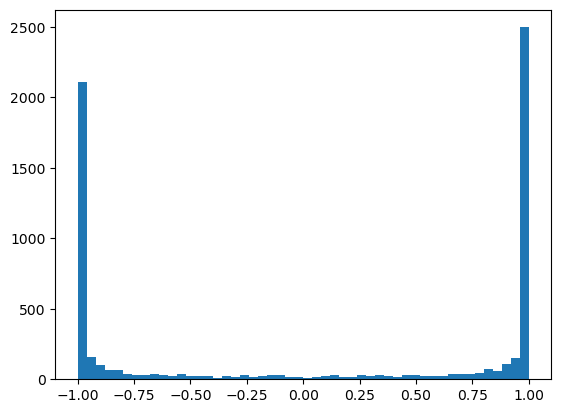

In [59]:
# to visualize this vector h and also the preactivation that goes into tanh.
# we will see that in h lots numbers take on extreme values, because the distribution of hpreact is very wide.
# tanh output value of 1 or -1 is killing any gradients flowing though tanh during backprop.
# intuitively, if you are in the flat region of tanh, changing input will not impact the output
# very much, i.e. the gradient is vanishing!

plt.hist(gr.view(-1).tolist(), 50);

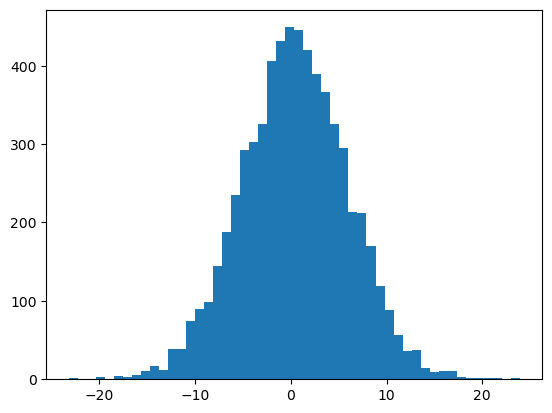

In [60]:
plt.hist(hpreact.view(-1).tolist(), 50);

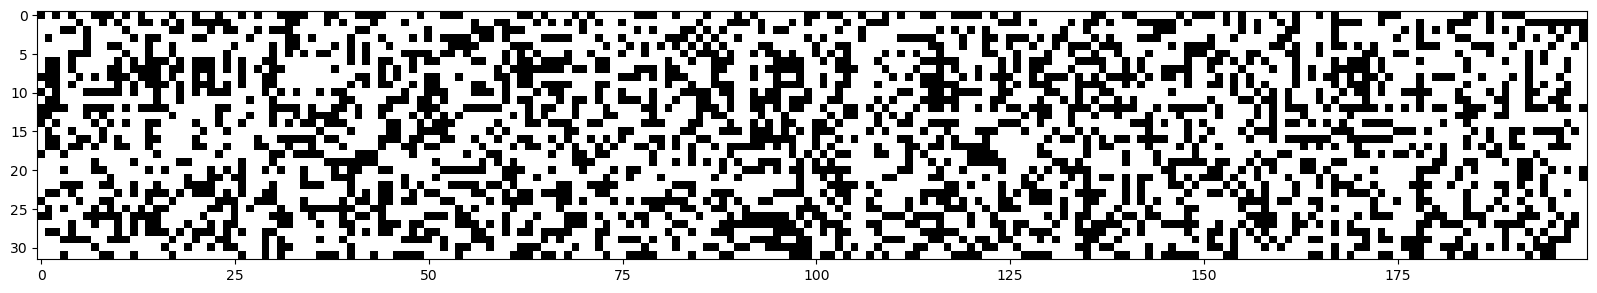

In [62]:
# we want to get a sense of how many of tanh ouputs are in the flat region.
# below we aer looking at 200 neurons for 30 samples.
# white spots are very activated neurons for a sample -- they are in the flat tails of tanh -- all their
# gradients are destroyed!

plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');


# how to fix this?
# make hpreact closer to zero!!

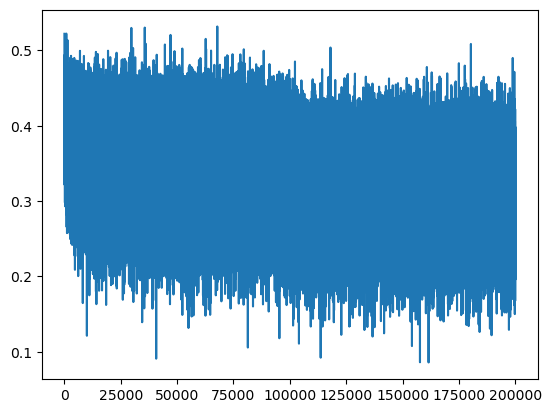

In [53]:
plt.plot(lossi)

# Cleaned up code

In [70]:
# network init

vocab_size = len(itos)
N_EMBD = 10  # the dim of the char embedding vectors
N_HIDDEN = 200  # the nunber of neurons in the hidden layer of model

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, N_EMBD),             generator=g)
W1 = torch.randn((N_EMBD * BLOCK_SIZE, N_HIDDEN), generator=g) * (5/3)/((N_EMBD * BLOCK_SIZE)**0.5)
b1 = torch.randn(N_HIDDEN,                        generator=g) * 0.01
W2 = torch.randn((N_HIDDEN, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# shift and scale in batch norm
# we initialize them to be 1s and 0s, so that the initial setting of batch norm layer
# is normalizing the previous layer, but then the network can learn to shift and scale
# the normalization layer to do what it wants. pretty wild!
gamma = torch.ones((1, N_HIDDEN))
beta = torch.zeros((1, N_HIDDEN))
bnmean_running = torch.zeros(N_HIDDEN)
bnstd_running = torch.ones(N_HIDDEN)

parameters = [C, W1, b1, W2, b2, gamma, beta]
print(sum([p.nelement() for p in parameters]))  # number of parameters in total

for p in parameters:
    p.requires_grad = True

12297


In [71]:
for p in parameters:
    print(p.shape, p.mean(), p.std())

torch.Size([27, 10]) tensor(-0.0193, grad_fn=<MeanBackward0>) tensor(1.0007, grad_fn=<StdBackward0>)
torch.Size([30, 200]) tensor(0.0039, grad_fn=<MeanBackward0>) tensor(0.3107, grad_fn=<StdBackward0>)
torch.Size([200]) tensor(0.0002, grad_fn=<MeanBackward0>) tensor(0.0102, grad_fn=<StdBackward0>)
torch.Size([200, 27]) tensor(-1.3349e-05, grad_fn=<MeanBackward0>) tensor(0.0100, grad_fn=<StdBackward0>)
torch.Size([27]) tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<StdBackward0>)
torch.Size([1, 200]) tensor(1., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<StdBackward0>)
torch.Size([1, 200]) tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<StdBackward0>)


In [73]:
# training loop

max_steps = 200000
batch_size = 32
lossi = []
stepi = []

for i in range(max_steps):
    
    # mini batch constrcut
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    # forward pass
    emb = C[Xtr[ix]]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1  # hidden layer pre-activation
    # batch norm: if you like hidden states to be unit gaussian, you just normalize them to be unit gaussian :o
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = gamma * (hpreact - bnmeani) / bnstdi + beta # batch norm!!

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    

    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    # ---- the next 3 lines are what's called the "cross entropy" function ----
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdim=True)
    # loss = -probs[torch.arange(probs.shape[0]), Y].log().mean() # likelihood estimation
    loss = F.cross_entropy(logits, Ytr[ix]) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

      0/ 200000: 3.318629
  10000/ 200000: 2.176923
  20000/ 200000: 1.994793
  30000/ 200000: 2.098684
  40000/ 200000: 2.245682
  50000/ 200000: 2.112484
  60000/ 200000: 2.304268
  70000/ 200000: 2.150178
  80000/ 200000: 2.276001
  90000/ 200000: 1.927685
 100000/ 200000: 2.373028
 110000/ 200000: 1.934428
 120000/ 200000: 2.067872
 130000/ 200000: 2.005432
 140000/ 200000: 2.354217
 150000/ 200000: 2.091670
 160000/ 200000: 1.817272
 170000/ 200000: 2.034137
 180000/ 200000: 2.198974
 190000/ 200000: 2.271470
2.1685855388641357


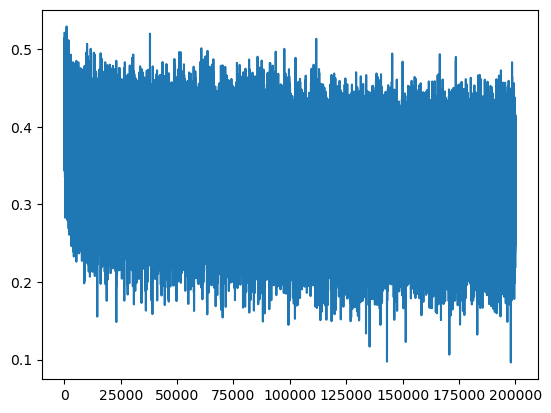

In [74]:
plt.plot(stepi, lossi);

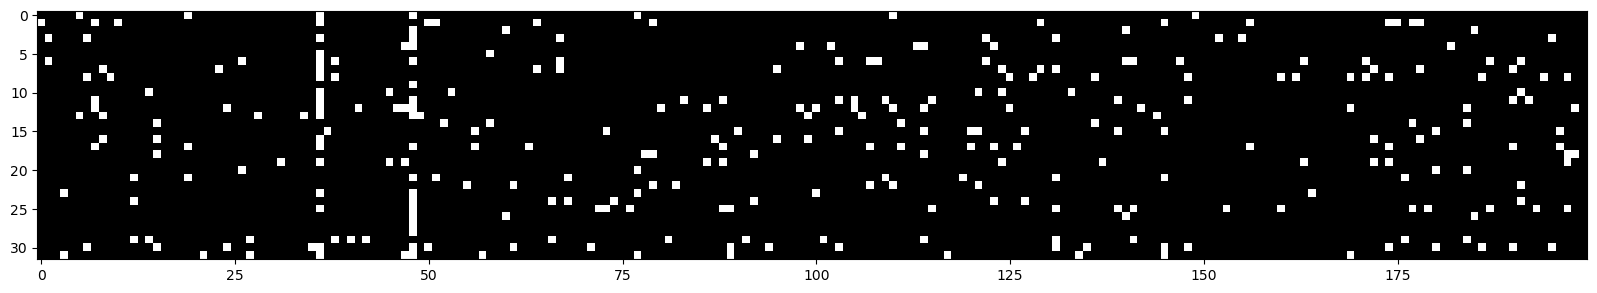

In [75]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

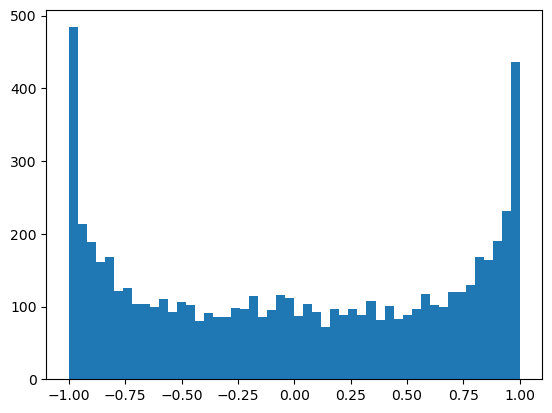

In [76]:
plt.hist(h.view(-1).tolist(), 50);

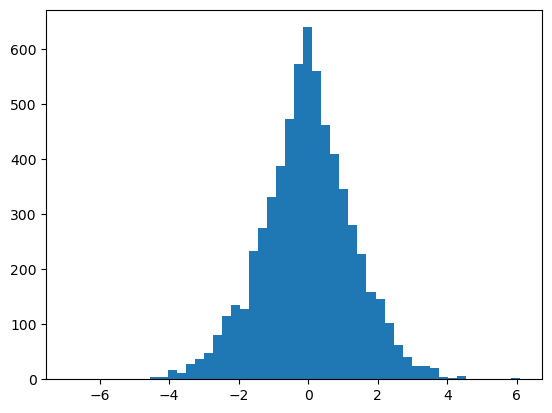

In [77]:
plt.hist(hpreact.view(-1).tolist(), 50);

tensor(-0.0167) tensor(0.9915)
tensor(-0.0013) tensor(0.9789)


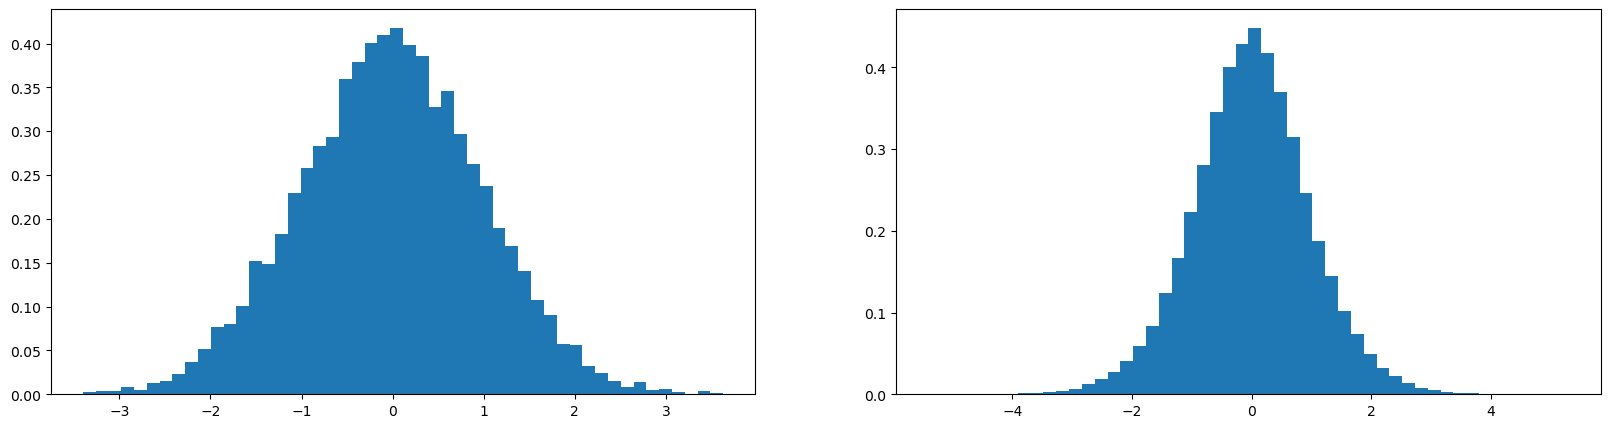

In [78]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [82]:
# evaluation

@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
    hpreact = gamma * (hpreact - bnmean_running) / bnstd_running + beta
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.067669630050659
val 2.1086599826812744
test 2.1079747676849365


In [90]:
# sample from the model

# g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * BLOCK_SIZE
    while True:
        emb = C[torch.tensor([context])] # (1, blcok_size, d)
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1 # + b1
        hpreact = gamma * (hpreact - bnmean_running) / bnstd_running + beta
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(
            probs,
            num_samples=1,
            # generator=g
        ).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

nez.
ili.
aufondaleen.
rak.
saiden.
acolbernah.
issorianni.
baylana.
cona.
jari.
kharisme.
evellin.
maraire.
amelle.
ewme.
ayda.
hila.
abdhelisabriann.
lam.
breshawn.


# Torchafy the NN and training code

In [258]:
# torchify the network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # what about the (5/3) factor?
        self.W = torch.randn((fan_in, fan_out), generator=g) / (fan_in**0.5)
        self.b = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        # why storing in attributes?
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.weight] if self.b is None else [self.W, self.b]


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained wtih backprop), i.e. scale and shift
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffes
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else: # use running mean and var for inference
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # apply the trained scale and shift params
        # accumulate running mean and var during training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
      
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [259]:
# network init

vocab_size = len(itos)
N_EMBD = 10  # the dim of the char embedding vectors
N_HIDDEN = 100  # the nunber of neurons in the hidden layer of model
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, N_EMBD), generator=g)
layers = [
    Linear(N_EMBD * BLOCK_SIZE, N_HIDDEN), BatchNorm1d(N_HIDDEN), Tanh(),
    Linear(N_HIDDEN, N_HIDDEN), BatchNorm1d(N_HIDDEN), Tanh(),
    Linear(N_HIDDEN, N_HIDDEN), BatchNorm1d(N_HIDDEN), Tanh(),
    Linear(N_HIDDEN, N_HIDDEN), BatchNorm1d(N_HIDDEN), Tanh(),
    Linear(N_HIDDEN, N_HIDDEN), BatchNorm1d(N_HIDDEN), Tanh(),
    Linear(N_HIDDEN, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].W *= 0.1
    # all other layers: apply gain to offset tanh compression
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= (5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


# training loop

max_steps = 100000
batch_size = 32
lossi = []
stepi = []
ud = []

for i in range(max_steps):
    
    # mini batch constrcut
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    print('loss', loss.item())
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break

47551
loss 3.304919719696045
loss 3.293065071105957
loss 3.323509931564331
loss 3.276973247528076
loss 3.2771430015563965
loss 3.253709077835083
loss 3.3028783798217773
loss 3.2746925354003906
loss 3.294694662094116
loss 3.2327749729156494
loss 3.247030019760132
loss 3.26254940032959
loss 3.2486002445220947
loss 3.219468116760254
loss 3.2540340423583984
loss 3.2369256019592285
loss 3.220475673675537
loss 3.269765853881836
loss 3.2232306003570557
loss 3.203784227371216
loss 3.210509777069092
loss 3.198255777359009
loss 3.181159734725952
loss 3.173583507537842
loss 3.2203528881073
loss 3.2413532733917236
loss 3.1442880630493164
loss 3.155496597290039
loss 3.205214023590088
loss 3.210895299911499
loss 3.158327102661133
loss 3.1927902698516846
loss 3.158958911895752
loss 3.215660572052002
loss 3.1711878776550293
loss 3.1483452320098877
loss 3.1686604022979736
loss 3.1043758392333984
loss 3.0728821754455566
loss 3.189321517944336
loss 3.096193313598633
loss 3.125197172164917
loss 3.14049577

layer 2 (      Tanh): mean: -0.00, std: 0.63, saturation: 2.09%
layer 5 (      Tanh): mean: -0.00, std: 0.65, saturation: 2.03%
layer 8 (      Tanh): mean: -0.00, std: 0.64, saturation: 2.16%
layer 11 (      Tanh): mean: -0.00, std: 0.64, saturation: 2.44%
layer 14 (      Tanh): mean: -0.00, std: 0.65, saturation: 2.00%


Text(0.5, 1.0, 'activation distribution')

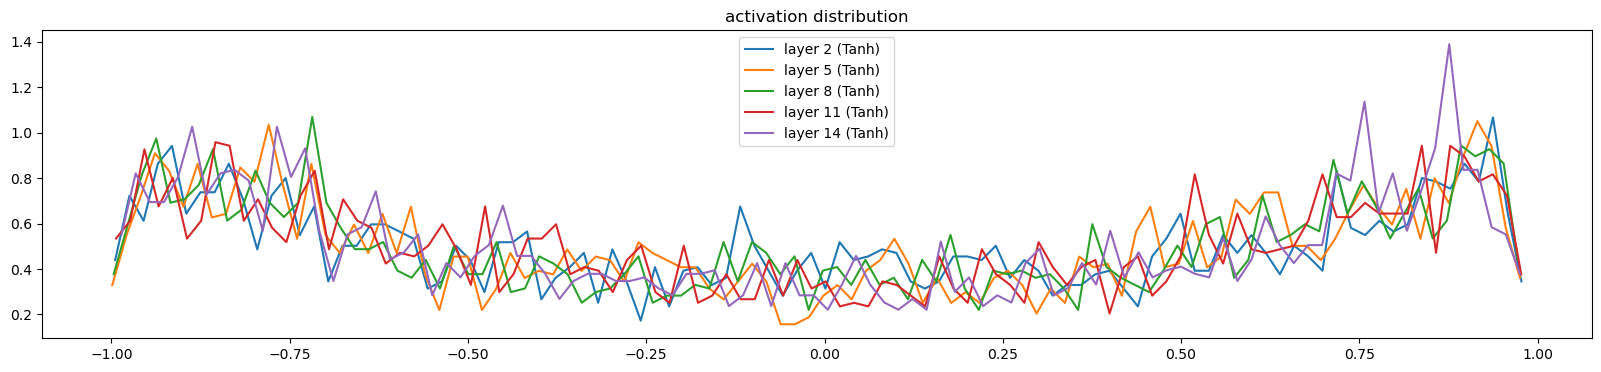

In [260]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean: %+.2f, std: %.2f, saturation: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean: -0.000000, std: 3.599791e-03
layer 5 (      Tanh): mean: -0.000000, std: 2.895435e-03
layer 8 (      Tanh): mean: -0.000000, std: 2.675042e-03
layer 11 (      Tanh): mean: +0.000000, std: 2.336664e-03
layer 14 (      Tanh): mean: +0.000000, std: 2.267943e-03


Text(0.5, 1.0, 'gradient distribution')

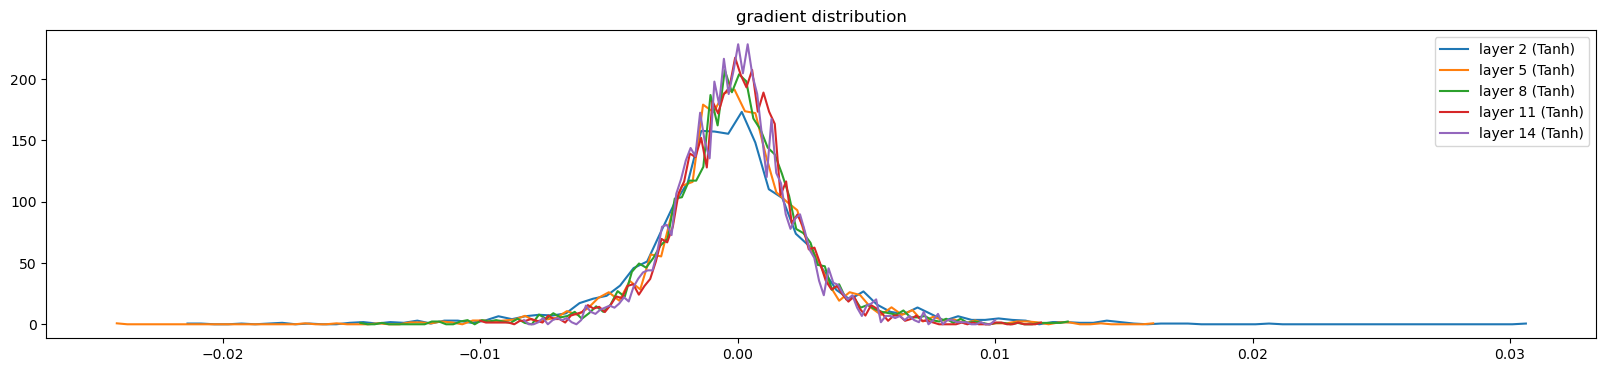

In [261]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean: %+f, std: %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

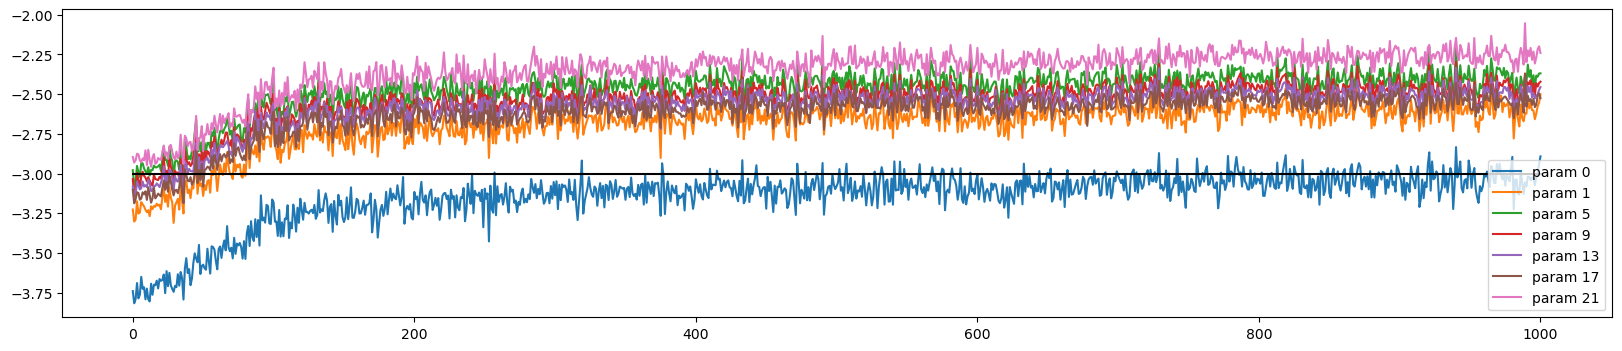

In [262]:
# update to data ratios

plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);